In [1]:
import sys
import os
from tqdm import tqdm
import random
import numpy as np
import math
# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir)

#import simtrain
from simtrain.sim_models_new import User_simmulation_Model
from simtrain import SETTINGS_POLIMI as SETTINGS
from simtrain import explore_models, process_dat
import simtrain.utils as utils
from simtrain.Dataset import CustomDataset
from simtrain.train import train, train_with_negatives

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import ast

import paths
from os.path import join
import pytorch_warmup as warmup


In [2]:
#num_items = 7
#num_items_per_recom = 2
num_interaction_types = 2
recom_dim = 1
#num_users = 11
#min_inter = 2
#max_inter = 4
state_size = SETTINGS.STATE_SIZE
subset = 50 # make data smaller
experiment_name = "new_negative2"
num_negatives = 40

In [3]:
#create dataset from processed data
'''
train_dat, stg = process_dat.load_dat(paths.cw_stages['output_new']['train'], new_data=True)

print(stg)

def convert_string_to_double_list(s):
    return ast.literal_eval(s)

# Apply the custom function
train_dat['item_ids'] = train_dat['item_ids'].apply(convert_string_to_double_list)
train_dat['user_means'] = train_dat['user_means'].apply(convert_string_to_double_list)
train_dat['user_vars_log'] = train_dat['user_vars_log'].apply(convert_string_to_double_list)
train_dat['timestamps'] = train_dat['timestamps'].apply(convert_string_to_double_list)
train_dat['interaction_types'] = train_dat['interaction_types'].apply(convert_string_to_double_list)

print("len: ", len(train_dat))
list_of_dicts = train_dat.to_dict(orient='records')
list_of_dicts = list_of_dicts[:subset]
train_dat.head()
'''

{'NI': 14, 'NU': 328, 'T': '[9.708333333333334, 12.4375, 12.604166666666666, 13.395833333333334, 15.458333333333334, 15.979166666666666, 17.333333333333332, 18.6875, 20.58333333333333, 21.354166666666668, 21.375, 21.39583333333333, 21.416666666666668, 21.4375, 21.45833333333333, 21.479166666666668, 22.52083333333333, 24.39583333333333, 24.416666666666668, 24.4375, 24.45833333333333, 24.479166666666668, 24.5, 24.52083333333333, 25.479166666666668, 25.5, 25.52083333333333, 25.541666666666668, 25.58333333333333, 25.64583333333333, 29.33333333333333, 30.14583333333333, 30.58333333333333, 30.604166666666668, 30.625, 30.979166666666668, 32.0, 34.354166666666664, 36.66666666666666, 36.6875, 37.5625, 37.583333333333336, 38.583333333333336, 43.10416666666666, 43.333333333333336]', 'NS': 100, 'INF_TIME': 1000}
len:  328


,user_id,user_means,user_vars_log,item_ids,timestamps,interaction_types
0,188,"[0.04783848150114567, 0.7924748444992165, -0.9...","[-4.548759966682498, -3.073818977358924, -0.91...","[[119, 74, 263, 144, 261, 53, 217, 194, 178, 2...","[5.416666666666667, 12.25, 13.645833333333334,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,491,"[0.9822065088026923, -0.30920177438877716, -0....","[-1.7784866608889747, -0.999038985048541, -0.1...","[[144, 279, 79, 84, 74, 247, 162, 165, 161, 13...","[54.35416666666666, 57.270833333333336, 57.354...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ..."
2,561,"[-0.6958705564906345, -0.9186835528229786, -0....","[-1.7702656832363624, -4.848853170981278, -0.2...","[[106, 125, 158, 27, 269, 264, 110, 50, 19, 16...","[20.58333333333333, 26.64583333333333, 28.5625...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,670,"[-0.20785380515949425, -0.576465807579132, -0....","[-4.164488517462706, -4.8280370081718305, -2.0...","[[165, 157, 187, 155, 95, 202, 99, 237, 288, 5...","[20.33333333333333, 26.39583333333333, 35.3125...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,749,"[0.991729030223963, -0.13849834840449438, 0.61...","[-2.553989406915311, -4.1900085632639765, -1.4...","[[161, 199, 279, 12, 37, 84, 74, 132, 161, 284...","[5.083333333333333, 6.395833333333333, 11.8125...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [4]:

checkpoint = torch.load(join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "data.h5"))
list_of_dicts = checkpoint['data']

In [5]:
'''
def adjust_hidden_dim(data_dict, state_size):
    # just to jumstart experiments should be deleted at the end
    for row in list_of_dicts:
        if row["user_means"] > state_size:
            row["user_means"] = row["user_means"][:state_size]
            row["user_vars_log"] = row["user_vars_log"][:state_size]
        elif row["user_means"] > state_size:


adjust_hidden_dim(list_of_dicts, state_size)
'''

'\ndef adjust_hidden_dim(data_dict, state_size):\n    # just to jumstart experiments should be deleted at the end\n    for row in list_of_dicts:\n        if row["user_means"] > state_size:\n            row["user_means"] = row["user_means"][:state_size]\n            row["user_vars_log"] = row["user_vars_log"][:state_size]\n        elif row["user_means"] > state_size:\n\n\nadjust_hidden_dim(list_of_dicts, state_size)\n'

In [4]:

dataset = CustomDataset(list_of_dicts[:30]) # [:30]
# Example usage with DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)# can only do batchsize 1

In [5]:
def test_timestamps(dataloader):
    smallest = float("inf")
    biggest = -1
    for batch in dataloader:
        timestamps, items, labels, means, var, idx = batch
        last = timestamps[0]
        smallest = min(smallest, last)
        biggest = max(biggest, timestamps[-1])
        for i in range(1,len(timestamps)):
            if timestamps[i] <= last:
                print("error, current: ", timestamps[i], "\tlast", last)
    smallest, biggest= int(smallest), float(biggest)
    print(smallest), print(biggest)
    return biggest

max_time = test_timestamps(dataloader)

0
69.33333333333333


In [6]:
for batch in dataloader:
    timestamps, items, labels, means, var, idx = batch
    print('Timestamps:', timestamps#, "\n dtype: ", timestamps.dtype
          )
    print('item_recom:', items#, "\n dtype: ", items.dtype
          )
    print('Labels:', labels#, "\n dtype: ", labels.dtype
          )
    print('means:', means#, "\n dtype: ", means.dtype
          )
    print('log_var:', var#, "\n dtype: ", var.dtype
          )
    break
    

Timestamps: [tensor([1.3750], dtype=torch.float64), tensor([15.5625], dtype=torch.float64), tensor([15.6042], dtype=torch.float64), tensor([19.2292], dtype=torch.float64), tensor([19.2917], dtype=torch.float64), tensor([38.3333], dtype=torch.float64)]
item_recom: [[tensor([217]), tensor([2]), tensor([53]), tensor([66]), tensor([297]), tensor([50]), tensor([199]), tensor([192]), tensor([77]), tensor([2]), tensor([57]), tensor([31]), tensor([109]), tensor([153]), tensor([88]), tensor([103]), tensor([205]), tensor([217]), tensor([60]), tensor([20]), tensor([238]), tensor([159]), tensor([203]), tensor([178]), tensor([254]), tensor([168]), tensor([298]), tensor([205]), tensor([2]), tensor([138]), tensor([20]), tensor([77]), tensor([50]), tensor([297]), tensor([66]), tensor([205]), tensor([57]), tensor([53]), tensor([66]), tensor([297]), tensor([50]), tensor([192]), tensor([153]), tensor([199]), tensor([217]), tensor([238]), tensor([88]), tensor([199]), tensor([50]), tensor([192]), tensor([6

In [14]:
# parameter dicts
width= 10
user_state_dict = {"model_hyp": {"layer_width": [width, width, width]}}
intensity_state_dict = {"model_hyp": {"user_model_hyp": {"layer_width": [width, width],
                                                         "noise": 0},
                                          "global_model_hyp": {"layer_width": [width, 3]}}
                            }
interaction_state_dict = {"model_hyp": {"layer_width": [width, width ,width]}
                            }
jump_state_dict = {"model_hyp": {"layer_width": [width, width]}
                        }

In [15]:
import torch.optim as optim

hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, "num_interaction_outcomes": num_interaction_types,
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "recom_dim":recom_dim, "interaction_model": interaction_state_dict,
                            "jump_model": jump_state_dict, "user_params_size": state_size}
model = User_simmulation_Model(hyperparameter_dict)

In [9]:
# load model
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "user_model.h5")
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [16]:
num_epochs = 5
warmup_period = len(dataset)
num_steps = num_epochs*len(dataset) -warmup_period
num_iter_til_first_restart = num_steps//2
user_lr = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(model.parameters(), lr=0.02,
                        weight_decay=1e-7)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=5e-5)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


Using device: cpu


In [17]:
utils.print_user_params(dataloader, print_var = True)

means:  [tensor([-0.1650], dtype=torch.float64), tensor([-0.8327], dtype=torch.float64), tensor([-0.0119], dtype=torch.float64), tensor([0.5459], dtype=torch.float64)]
logvar:  [tensor([-1.1950], dtype=torch.float64), tensor([-4.4349], dtype=torch.float64), tensor([-0.4462], dtype=torch.float64), tensor([-3.3404], dtype=torch.float64)]
means:  [tensor([-0.2079], dtype=torch.float64), tensor([-0.5765], dtype=torch.float64), tensor([-0.4390], dtype=torch.float64), tensor([-0.7407], dtype=torch.float64)]
logvar:  [tensor([-4.1645], dtype=torch.float64), tensor([-4.8280], dtype=torch.float64), tensor([-2.0535], dtype=torch.float64), tensor([-2.3040], dtype=torch.float64)]
means:  [tensor([-0.7124], dtype=torch.float64), tensor([0.0909], dtype=torch.float64), tensor([-0.2352], dtype=torch.float64), tensor([-0.3719], dtype=torch.float64)]
logvar:  [tensor([-4.4651], dtype=torch.float64), tensor([-2.6311], dtype=torch.float64), tensor([-2.4612], dtype=torch.float64), tensor([-1.5865], dtype=t

In [18]:
# no negative samples
'''
train(model, dataloader=dataloader, num_epochs=num_epochs, device=device, loss_func=utils.loss_func, 
                loss_func_kl=utils.kl_loss, kl_weight=1., user_lr=user_lr,
                optimizer=optimizer, lr_scheduler=lr_scheduler, num_classes=num_interaction_types, 
                logger=utils.logging_func,warmup_period=warmup_period, intensity_loss_func=utils.square_intensity_loss,
                state_size=state_size,max_time=max_time, log_step_size=1, warmup_scheduler = warmup_scheduler,
                )
'''

'\ntrain(model, dataloader=dataloader, num_epochs=num_epochs, device=device, loss_func=utils.loss_func, \n                loss_func_kl=utils.kl_loss, kl_weight=1., user_lr=user_lr,\n                optimizer=optimizer, lr_scheduler=lr_scheduler, num_classes=num_interaction_types, \n                logger=utils.logging_func,warmup_period=warmup_period, intensity_loss_func=utils.square_intensity_loss,\n                state_size=state_size,max_time=max_time, log_step_size=1, warmup_scheduler = warmup_scheduler,\n                )\n'

In [19]:
train_with_negatives(model, dataloader=dataloader, num_epochs=num_epochs, device=device, 
                loss_func=utils.loss_func, loss_func_kl=utils.kl_loss, kl_weight=1., 
                user_lr=user_lr, optimizer=optimizer, lr_scheduler=lr_scheduler, 
                num_classes=num_interaction_types, logger=utils.logging_func,
                warmup_period=warmup_period, intensity_loss_func=utils.log_loss,
                state_size=state_size,max_time=max_time, log_step_size=1, warmup_scheduler = warmup_scheduler,
                num_negatives=num_negatives, positive_examples_weight=1,
                )

  0%|          | 0/5 [00:00<?, ?it/s]


AssertionError: underflow in dt 0.0

In [ ]:
utils.print_user_params(dataloader, print_var = True)

means:  [tensor([0.0020], dtype=torch.float64), tensor([0.0003], dtype=torch.float64), tensor([-0.0003], dtype=torch.float64)]
logvar:  [tensor([-0.5196], dtype=torch.float64), tensor([-0.5196], dtype=torch.float64), tensor([-0.5196], dtype=torch.float64)]
means:  [tensor([-0.0076], dtype=torch.float64), tensor([-0.0022], dtype=torch.float64), tensor([0.0018], dtype=torch.float64)]
logvar:  [tensor([-0.5774], dtype=torch.float64), tensor([-0.5774], dtype=torch.float64), tensor([-0.5774], dtype=torch.float64)]
means:  [tensor([0.0010], dtype=torch.float64), tensor([0.0013], dtype=torch.float64), tensor([-0.0005], dtype=torch.float64)]
logvar:  [tensor([-0.5196], dtype=torch.float64), tensor([-0.5196], dtype=torch.float64), tensor([-0.5196], dtype=torch.float64)]
means:  [tensor([-0.0024], dtype=torch.float64), tensor([0.1395], dtype=torch.float64), tensor([-0.1428], dtype=torch.float64)]
logvar:  [tensor([-0.4619], dtype=torch.float64), tensor([-0.4619], dtype=torch.float64), tensor([-0

In [9]:
#save model
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "user_model.h5")

torch.save(model.state_dict(), path)

In [10]:
# save data(changes during training)
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "data.h5")
torch.save({
    'data': dataloader.dataset.data,
}, path,
)


total visits for user 6
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


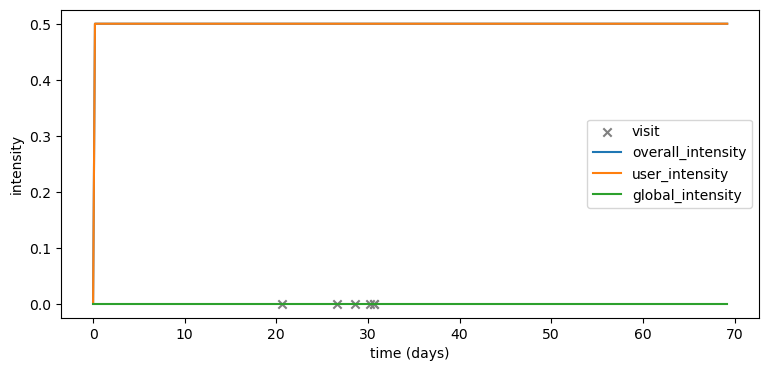

In [ ]:
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2)